In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['DISPLAY'] = ':1'
os.environ['NAPARI_ASYNC'] = '1'


from SyMBac.simulation import Simulation
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import Renderer
from SyMBac.PSF import Camera
from SyMBac.misc import get_sample_images
real_image = get_sample_images()["E. coli 100x"]
from joblib import Parallel, delayed


In [3]:
my_simulation = Simulation(
    trench_length=15,
    trench_width=1.15,
    cell_max_length=6.65, #6, long cells # 1.65 short cells
    cell_width= 1, #1 long cells # 0.95 short cells
    sim_length = 200,
    pix_mic_conv = 0.065,
    gravity=0,
    phys_iters=15,
    max_length_var = 0.,
    width_var = 0.,
    lysis_p = 0.00,
    save_dir="/tmp/test/",
    resize_amount = 3,
)

In [21]:
my_simulation.run_simulation()

  0%|          | 0/202 [00:00<?, ?it/s]

In [37]:
IDs = []
for t in my_simulation.cell_timeseries:
    for cell in t:
        IDs.append(cell.mask_label)


In [40]:
len(np.unique(IDs))

26

In [5]:
from tqdm.auto import tqdm

In [6]:
from copy import deepcopy
class ParallelSimulation:

    def __init__(self, simulation, N):
        self.simulations = [deepcopy(simulation) for x in range(N)]

        for i, simulation in enumerate(self.simulations):
            init_args = simulation.__dict__
            init_args["save_dir"] += f"/parsim_{str(i)}/"
            simulation.__init__(**init_args)
            simulation.show_progress = False

    def run_simulations(self):
        def run_single_simulation(simulation): # Needed to avoid joblib's shared mem requirement
            simulation.run_simulation()
            return simulation
        
        self.simulations = Parallel(n_jobs=-1)(
            delayed(run_single_simulation)(sim) for sim in tqdm(self.simulations)
        )

In [13]:
parsim = ParallelSimulation(my_simulation, 20)

In [14]:
parsim.run_simulations()

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
import napari
import numpy as np

# add the image
viewer = napari.Viewer()
viewer.dims.ndim=4
shapes = []
for s, simulation in enumerate(parsim.simulations):
    for t, cell_list in enumerate(simulation.cell_timeseries):
        for cell in cell_list:
            verts = np.array(cell.get_vertex_list())[::7]
            t_array = np.expand_dims(np.repeat(t, verts.shape[0]),1)
            sim_array = np.expand_dims(np.repeat(s, verts.shape[0]),1)
            verts = np.concatenate([sim_array,t_array, verts], axis = 1)
            shapes.append(verts)

#viewer.dims.set_range(0,(0,len(my_simulation.cell_timeseries),1))


In [16]:
viewer.add_shapes(shapes, shape_type='polygon',
                          edge_color='coral', face_color='royalblue', name="Cells")

<Shapes layer 'Cells' at 0x78325db66320>

In [5]:
import napari
from napari import Viewer
from napari.layers import Image, Labels, Shapes
from magicgui.tqdm import tqdm as magic_tqdm
import numpy as np


In [6]:
from itertools import cycle

In [7]:
40 % 100

40

In [8]:
from magicgui import magicgui, use_app
use_app("qt")
viewer = napari.Viewer()

# Define a function to create the Simulation object
@magicgui(
    auto_call=False,
    trench_length={"label": "Trench Length"},
    trench_width={"label": "Trench Width"},
    cell_max_length={"label": "Cell Max Length"},
    cell_width={"label": "Cell Width"},
    sim_length={"label": "Simulation Length"},
    pix_mic_conv={"label": "Pixel-Micrometer Conversion"},
    gravity={"label": "Gravity"},
    phys_iters={"label": "Physical Iterations"},
    max_length_var={"label": "Max Length Variation"},
    width_var={"label": "Width Variation"},
    lysis_p={"label": "Lysis Probability"},
    save_dir={"label": "Save Directory"},
    resize_amount={"label": "Resize Amount"},
)
def create_simulation(
    viewer: Viewer,
    trench_length: float = 15.0,
    trench_width: float = 1.15,
    cell_max_length: float = 6.65,
    cell_width: float = 1.0,
    sim_length: int = 200,
    pix_mic_conv: float = 0.065,
    gravity: float = 0.0,
    phys_iters: int = 15,
    max_length_var: float = 0.0,
    width_var: float = 0.0,
    lysis_p: float = 0.0,
    save_dir: str = "/tmp/test/",
    resize_amount: int = 3,
) -> Shapes:
    my_simulation = Simulation(
        trench_length=trench_length,
        trench_width=trench_width,
        cell_max_length=cell_max_length,
        cell_width=cell_width,
        sim_length=sim_length,
        pix_mic_conv=pix_mic_conv,
        gravity=gravity,
        phys_iters=phys_iters,
        max_length_var=max_length_var,
        width_var=width_var,
        lysis_p=lysis_p,
        save_dir=save_dir,
        resize_amount=resize_amount,
        show_progress="magicgui"
    )
    my_simulation.pbar = magic_tqdm
    my_simulation.run_simulation(show_window = False)

    shapes = []
    colours = []
    cmap = napari.utils.colormaps.label_colormap(100).colors
    for t, cell_list in enumerate(my_simulation.cell_timeseries):
        for cell in cell_list:
            verts = np.array(cell.get_vertex_list())[::5,::-1]
            t_array = np.expand_dims(np.repeat(t, verts.shape[0]),1)
            verts = np.concatenate([t_array, verts], axis = 1)
            shapes.append(verts)
            colours.append(cmap[cell.mask_label % len(cmap)])
    viewer.dims.current_step = (0,0,0)

    return Shapes(shapes, name="Simulation output", shape_type='polygon',edge_color='coral', face_color=colours)

# Show the GUI
viewer.window.add_dock_widget(create_simulation, name="Create Simulation")

03-Jul-24 03:21:21 - SyMBac.simulation - INFO     - Initializing Simulation object
03-Jul-24 03:21:21 - SyMBac.simulation - DEBUG    - {'trench_length': 15.0, 'trench_width': 1.15, 'cell_max_length': 1.5, 'max_length_var': 0.0, 'cell_width': 1.0, 'width_var': 0.0, 'lysis_p': 0.0, 'sim_length': 200, 'pix_mic_conv': 0.07, 'gravity': 0.0, 'phys_iters': 15, 'resize_amount': 3, 'save_dir': '/tmp/test/', 'load_sim_dir': None, 'sim_callback': None, 'show_progress': 'magicgui'}
03-Jul-24 03:21:52 - SyMBac.simulation - INFO     - Initializing Simulation object
03-Jul-24 03:21:52 - SyMBac.simulation - DEBUG    - {'trench_length': 15.0, 'trench_width': 1.15, 'cell_max_length': 1.5, 'max_length_var': 0.0, 'cell_width': 0.75, 'width_var': 0.0, 'lysis_p': 0.0, 'sim_length': 200, 'pix_mic_conv': 0.07, 'gravity': 0.0, 'phys_iters': 15, 'resize_amount': 3, 'save_dir': '/tmp/test/', 'load_sim_dir': None, 'sim_callback': None, 'show_progress': 'magicgui'}
03-Jul-24 03:22:35 - SyMBac.simulation - INFO    

In [71]:
from magicgui import magicgui, use_app
use_app("ipynb")
from magicgui.tqdm import tqdm as magic_tqdm

from magicgui import magicgui

# Define a function to create the Simulation object
@magicgui(
    auto_call=False,
    trench_length={"label": "Trench Length"},
    trench_width={"label": "Trench Width"},
    cell_max_length={"label": "Cell Max Length"},
    cell_width={"label": "Cell Width"},
    sim_length={"label": "Simulation Length"},
    pix_mic_conv={"label": "Pixel-Micrometer Conversion"},
    gravity={"label": "Gravity"},
    phys_iters={"label": "Physical Iterations"},
    max_length_var={"label": "Max Length Variation"},
    width_var={"label": "Width Variation"},
    lysis_p={"label": "Lysis Probability"},
    save_dir={"label": "Save Directory"},
    resize_amount={"label": "Resize Amount"},
)
def create_simulation(
    trench_length: float = 15.0,
    trench_width: float = 1.15,
    cell_max_length: float = 6.65,
    cell_width: float = 1.0,
    sim_length: int = 200,
    pix_mic_conv: float = 0.065,
    gravity: float = 0.0,
    phys_iters: int = 15,
    max_length_var: float = 0.0,
    width_var: float = 0.0,
    lysis_p: float = 0.0,
    save_dir: str = "/tmp/test/",
    resize_amount: int = 3,
) -> Simulation:
    my_simulation = Simulation(
        trench_length=trench_length,
        trench_width=trench_width,
        cell_max_length=cell_max_length,
        cell_width=cell_width,
        sim_length=sim_length,
        pix_mic_conv=pix_mic_conv,
        gravity=gravity,
        phys_iters=phys_iters,
        max_length_var=max_length_var,
        width_var=width_var,
        lysis_p=lysis_p,
        save_dir=save_dir,
        resize_amount=resize_amount,
        show_progress="magicgui")
    my_simulation.pbar = magic_tqdm
    my_simulation.run_simulation(show_window=False)
# Show the GUI
create_simulation.show(run=True)


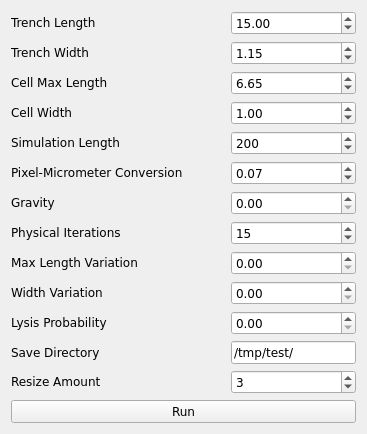

In [30]:
create_simulation

In [4]:
class NapariCallback:
    def __init__(self, viewer):
        self.viewer = viewer

    def __call__(self,simulation):
        shapes = []
        for t, cell_list in enumerate(my_simulation.cell_timeseries):
            for cell in cell_list:
                verts = np.array(cell.get_vertex_list())
                t_array = np.expand_dims(np.repeat(t, verts.shape[0]),1)
                verts = np.concatenate([t_array, verts], axis = 1)
                shapes.append(verts)

In [5]:
import napari

viewer = napari.Viewer()
viewer.dims.ndim=3
viewer.dims.set_range(0,(0,601,1))

In [6]:
my_simulation.run_simulation(show_window=False)

  0%|          | 0/202 [00:00<?, ?it/s]

In [39]:
import time
from tqdm.auto import tqdm
from napari.qt.threading import thread_worker


In [ ]:
viewer = napari.Viewer()
viewer.dims.ndim=3
viewer.dims.set_range(0,(0,len(my_simulation.cell_timeseries),1))

def update_shapes_layer(new_shapes):
    try:
        # if the layer exists, update the data
        viewer.layers['Cells'].data = viewer.layers['Cells'].data =  new_shapes
        viewer.dims.set_range(0,(0,len(my_simulation.cell_timeseries),1))
        viewer.dims.current_step = (t,0,0)
        time.sleep(1)
    except KeyError:
        # otherwise add it to the viewer
        viewer.add_shapes(new_shapes, shape_type='polygon',
                                  edge_color='coral', face_color='royalblue', name="Cells")
        viewer.dims.set_range(0,(0,len(my_simulation.cell_timeseries),1))
        viewer.dims.current_step = (t,0,0)
        time.sleep(1)    

    
@thread_worker(connect={'yielded': update_shapes_layer})
def add_cells():
    global t
    shapes = []
    for t, cell_list in enumerate(my_simulation.cell_timeseries):
        for cell in cell_list:
            verts = np.array(cell.get_vertex_list())
            t_array = np.expand_dims(np.repeat(t, verts.shape[0]),1)
            verts = np.concatenate([t_array, verts], axis = 1)
            shapes.append(verts)
    yield shapes

add_cells()

napari.run()


In [12]:
import numpy as np

In [13]:
a = add_cells()

In [11]:
import napari
import numpy as np
from napari.qt.threading import thread_worker


viewer = napari.Viewer()

def update_layer(new_image):
    try:
        # if the layer exists, update the data
        viewer.layers['result'].data = new_image
    except KeyError:
        # otherwise add it to the viewer
        viewer.add_image(
            new_image, contrast_limits=(0.45, 0.55), name='result'
        )

@thread_worker(connect={'yielded': update_layer})
def large_random_images():
    cumsum = np.zeros((512, 512))
    for i in range(1024):
        cumsum += np.random.rand(512, 512)
        if i % 16 == 0:
            yield cumsum / (i + 1)

large_random_images()  # call the function!
napari.run()


In [9]:
import napari
import numpy as np
from skimage import data

# add the image
viewer = napari.Viewer()
viewer.dims.ndim=3

for t, cell_list in enumerate(my_simulation.cell_timeseries):
    shapes = []
    for cell in cell_list:
        verts = np.array(cell.get_vertex_list())
        t_array = np.expand_dims(np.repeat(t, verts.shape[0]),1)
        verts = np.concatenate([t_array, verts], axis = 1)
        shapes.append(verts)
    if t == 0:
        # add the polygons
        shapes_layer = viewer.add_shapes(shapes, shape_type='polygon',
                                  edge_color='coral', face_color='royalblue', name="Cells")

    
viewer.dims.set_range(0,(0,len(my_simulation.cell_timeseries),1))


In [24]:
shapes = []
for t, cell_list in enumerate(my_simulation.cell_timeseries[10:20]):
    for cell in cell_list:
        verts = np.array(cell.get_vertex_list())
        t_array = np.expand_dims(np.repeat(t+10, verts.shape[0]),1)
        verts = np.concatenate([t_array, verts], axis = 1)
        shapes.append(verts)


In [33]:
viewer.layers["Cells"].data.extend(shapes)

In [36]:
viewer.layers["Cells"].data = viewer.layers["Cells"].data + shapes
viewer.dims.set_range(0,(0,len(my_simulation.cell_timeseries),1))


In [32]:
a_cell = my_simulation.cells[0]

In [13]:
from SyMBac.drawing import draw_scene, get_space_size, gen_cell_props_for_draw, generate_curve_props
from joblib import Parallel, delayed
from tqdm.auto import tqdm

from SyMBac.trench_geometry import trench_creator, get_trench_segments

def draw_simulation_OPL(simulation, do_transformation = True, label_masks = True, return_output = False): #TODO decouble drawing from simulation


    """
    Draw the optical path length images from the simulation. This involves drawing the 3D cells into a 2D numpy
    array, and then the corresponding masks for each cell.

    After running this function, the Simulation object will gain two new attributes: ``self.OPL_scenes`` and ``self.masks`` which can be accessed separately.

    :param bool do_transformation: Sets whether to transform the cells by bending them. Bending the cells can add realism to a simulation, but risks clipping the cells into the mother machine trench walls.

    :param bool label_masks: Sets whether the masks should be binary, or labelled. Masks should be binary is training a standard U-net, such as with DeLTA, but if training Omnipose (recommended), then mask labelling should be set to True.

    :param bool return_output: Controls whether the function returns the OPL scenes and masks. Does not affect the assignment of these attributes to the instance.

    Returns
    -------
    output : tuple(list(numpy.ndarray), list(numpy.ndarray))
       If ``return_output = True``, a tuple containing lists, each of which contains the entire simulation. The first element in the tuple contains the OPL images, the second element contains the masks

    """
    simulation.main_segments = get_trench_segments(simulation.space)
    ID_props = generate_curve_props(simulation.cell_timeseries)

    cell_timeseries_properties = Parallel(n_jobs=-1)(
        delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(simulation.cell_timeseries, desc='Extracting cell properties from the simulation'))

    space_size = get_space_size(cell_timeseries_properties)
    offset = 30
    scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, space_size, offset, label_masks) for cell_properties in tqdm(
        cell_timeseries_properties, desc='Rendering cell optical path lengths'))
    OPL_scenes = [_[0] for _ in scenes]
    masks = [_[1] for _ in scenes]

    return OPL_scenes, masks

In [14]:
OPL_scenes, masks = draw_simulation_OPL(simulation=my_simulation)

Extracting cell properties from the simulation:   0%|          | 0/300 [00:00<?, ?it/s]

Rendering cell optical path lengths:   0%|          | 0/300 [00:00<?, ?it/s]

In [15]:
import matplotlib.pyplot as plt

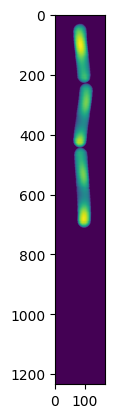

In [16]:
plt.imshow(OPL_scenes[-1])

In [5]:
from SyMBac.lineage import Lineage

In [6]:
my_lineage = Lineage(my_simulation)

In [9]:
import SyMBac
SyMBac.__version__

'0.4.8'

In [4]:
vars(my_simulation)

{'trench_length': 15,
 'trench_width': 1.15,
 'cell_max_length': 6.65,
 'max_length_var': 0.0,
 'cell_width': 1,
 'width_var': 0.0,
 'lysis_p': 0.0,
 'sim_length': 300,
 'pix_mic_conv': 0.065,
 'gravity': 0,
 'phys_iters': 15,
 'resize_amount': 3,
 'save_dir': '/tmp/test/',
 'offset': 30,
 'load_sim_dir': None}